## Data Preparation and Exploration.

This notebook is focused on preparing, cleaning and exploring a dataset recorded at a 15 minute interval. The temperature and humidity were also recorded at the site. Other associated weather data came from the nearest NOAA weather station available.

The goal is to apply this dataset to machine learning models to predict daily solar power plant output.


Points to look out for in a clean data:
* Making sure the data is presented in a way that makes sense with all the variables correct.
* Ensure that the variables make sense and are correct.
* Eliminating duplicate rows and columns as well as elimiating columns that provide redundant information.
* Dealing with missing data appropriately.


In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle

import warnings
warnings.filterwarnings("ignore")

### Preliminary Analysis






In [2]:
### Reading in the data
df_solar = pd.read_csv('Pasion et al dataset.csv')

In [11]:
df_solar.shape

df_solar.head(5)

,Location,Date,Time,Latitude,Longitude,Altitude,YRMODAHRMI,Month,Hour,Season,Humidity,AmbientTemp,PolyPwr,Wind.Speed,Visibility,Pressure,Cloud.Ceiling
0,Camp Murray,20171203,1145,47.11,-122.57,84,2.017120e+11,12,11,Winter,81.71997,12.86919,2.42769,5,10.0,1010.6,722
1,Camp Murray,20171203,1315,47.11,-122.57,84,2.017120e+11,12,13,Winter,96.64917,9.66415,2.46273,0,10.0,1011.3,23
2,Camp Murray,20171203,1330,47.11,-122.57,84,2.017120e+11,12,13,Winter,93.61572,15.44983,4.46836,5,10.0,1011.6,32
3,Camp Murray,20171204,1230,47.11,-122.57,84,2.017120e+11,12,12,Winter,77.21558,10.36659,1.65364,5,2.0,1024.4,6
4,Camp Murray,20171204,1415,47.11,-122.57,84,2.017120e+11,12,14,Winter,54.80347,16.85471,6.57939,3,3.0,1023.7,9


This dataset contains 21045 rows and 17 columns

### Cleaning

It will be fairly simple and easy because the majority of the labor-intensive cleaning was already completed by the data author. 

Initially, several of the columns won't be particularly helpful. The datetime is represented by `YRMODAHRMI` once again, but that is handled. In a similar vein, other columns like `Month` and `Hour` that include date and time information will be removed.

The other cleaning tasks to be done are, converting the cloud ceiling measurement to kilometers. This is the standard unit for NOAA and the maximum measurement is 22 kilometers. Finally, reordering the columns to put the target (or at least the proxy for the target) to the front, per convention.

In summary, the cleaning tasks involved are:
- convert cloud ceiling from feet to meters
- drop useless columns
- convert date and time from int to datetime
- reorder columns
- checking for missing data
- checking for duplicate rows and columns if any



In [12]:
df_copy = df_solar.copy()

# Converting date and time column to Date-Time format
dtype_converter = {
    "Date": str,
    "Time": str
}
df_copy = df_copy.astype(dtype_converter)

df_copy["DateTime"] = df_copy["Date"] + df_copy["Time"]
df_copy["DateTime"] = pd.to_datetime(df_copy["DateTime"], format="%Y%m%d%H%M")


# - convert cloud ceiling from feet to meters
df_copy["Cloud.Ceiling"] = df_copy["Cloud.Ceiling"]*100/3281 # hundreds of feet -> kilometers



##
df_copy = df_copy.drop(['YRMODAHRMI','Season','Date', 'Time','Hour'], axis=1)



df_copy.columns.values






array(['Location', 'Latitude', 'Longitude', 'Altitude', 'Month',
       'Humidity', 'AmbientTemp', 'PolyPwr', 'Wind.Speed', 'Visibility',
       'Pressure', 'Cloud.Ceiling', 'DateTime'], dtype=object)

In [13]:
df_copy = df_copy[['PolyPwr', 'Location', 'Latitude', 'Longitude', 'Altitude',
       'Humidity', 'AmbientTemp', 'Wind.Speed',
       'Visibility', 'Pressure', 'Cloud.Ceiling','Month','DateTime']]

df_copy = df_copy.set_index("DateTime")

In [14]:
df = df_copy.copy()


### Looking for null and missing values.

In [15]:
df_solar.isnull().sum()


Location         0
Date             0
Time             0
Latitude         0
Longitude        0
Altitude         0
YRMODAHRMI       0
Month            0
Hour             0
Season           0
Humidity         0
AmbientTemp      0
PolyPwr          0
Wind.Speed       0
Visibility       0
Pressure         0
Cloud.Ceiling    0
dtype: int64

### Checking for Duplicate rows/ redundant information

In [16]:
#Checking for duplicate rows
df_solar.duplicated().sum()


0

In [17]:
#Checking for duplicate columns
df_solar.T.duplicated()

Location         False
Date             False
Time             False
Latitude         False
Longitude        False
Altitude         False
YRMODAHRMI       False
Month            False
Hour             False
Season           False
Humidity         False
AmbientTemp      False
PolyPwr          False
Wind.Speed       False
Visibility       False
Pressure         False
Cloud.Ceiling    False
dtype: bool

## Feature Engineering
 For this project, we must predict the daily energy output. Thus, the features will be converted into daily energy output.

This is done by grouping the data into dates and then grouping those by location. For each unique location on a unique date, the daily output is calculated as :
$$E_{daily} = \int_{t_i}^{t_f}Pdt$$
where $P$ is the power output and $t$ is time. This gives the total energy output over the given time span.

For this case, the integral will be approximated numerically using the simple trapezoid formula. Instead of coding it by hand, numpy comes with a `trapz` method.

This energy output is specifically for 50W panels. To be able to scale it to a larger panel application, this energy output needs to be dimensionless. This is done by dividing the actual energy output by the rated energy output. This would be called efficiency. If an efficiency is predicted, it can simply be multiplied by the solar panel rating to get the estimated actual energy output. Therefore,  this efficiency will be the target variable.





In [20]:
d = {
    "date": [],
    "location": [],
    "daily_energy": [],
    "operation_time": [],
    "ideal_daily_energy": [],
    "Latitude": [],
    "Longitude": [],
    "Altitude": [],
    "Humidity": [],
    "AmbientTemp": [],
    "Wind.Speed": [],
    "Visibility": [],
    "Pressure": [],
    "Cloud.Ceiling": [],
    "Month": [],
    }

for unique_date in np.unique(df.index.date):
    for unique_location in df.loc[str(unique_date)]["Location"].unique():

        matching_date_df = df.loc[str(unique_date)]
        matching_date_and_loc = matching_date_df[matching_date_df["Location"]==unique_location]

        operation_time = matching_date_and_loc.index.max() - matching_date_and_loc.index.min()
        operation_time = operation_time.total_seconds()/3600 # hours
        if operation_time == 0:
            continue # skip if not operating that day
        ideal_output = operation_time * 50 # 50 Watt rated panel

        x = matching_date_and_loc.sort_index().index.values.astype(np.int64)//10 ** 9/3600
        y = matching_date_and_loc.sort_index()["PolyPwr"]
        daily_output = np.trapz(y, x) # Watt-hours unit

        d["date"].append(unique_date)
        d["location"].append(unique_location)
        d["operation_time"].append(operation_time)
        d["daily_energy"].append(daily_output)
        d["ideal_daily_energy"].append(ideal_output)

        for feature in df.drop(["Location", "PolyPwr"], axis=1).columns.values:
            d[feature].append(matching_date_and_loc[feature].mean())

daily_df = pd.DataFrame(d)
daily_df.head()

daily_df.shape

(3582, 15)

In [21]:
daily_df["Daily_efficiency"] = daily_df["daily_energy"]/daily_df["ideal_daily_energy"]

Extracting separate date-related components


In [22]:
daily_df["date"] = pd.to_datetime(daily_df["date"], format="%Y-%m-%d")
daily_df["Day"] = daily_df["date"].dt.day

In [23]:
df_solar = daily_df.drop([
    "operation_time", "daily_energy", "ideal_daily_energy", 
    "location", "date"], axis=1)


df_solar.describe()


,Latitude,Longitude,Altitude,Humidity,AmbientTemp,Wind.Speed,Visibility,Pressure,Cloud.Ceiling,Month,Daily_efficiency,Day
count,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000,3582.000000
mean,38.125882,-108.456226,758.036851,36.559933,29.196217,10.307284,9.752448,930.608966,16.145532,6.579564,0.269390,15.758794
std,6.546400,16.766465,756.225700,21.241312,11.427519,5.483647,0.988677,83.682765,7.602125,3.071649,0.119932,8.850453
min,20.890000,-156.440000,1.000000,0.067139,-17.170753,0.000000,0.266667,782.000000,0.053337,1.000000,0.009149,1.000000
25%,38.160000,-117.260000,2.000000,19.210434,22.464141,6.400000,10.000000,852.356429,10.226303,4.000000,0.175739,8.000000
50%,38.820000,-111.180000,458.000000,34.356690,30.746409,9.125000,10.000000,963.431250,22.005486,7.000000,0.286641,16.000000
75%,41.150000,-95.750000,1370.000000,50.099755,37.635068,13.600000,10.000000,1009.775000,22.005486,9.000000,0.365881,23.750000
max,47.520000,-80.110000,1947.000000,99.987790,58.385430,38.000000,10.000000,1028.800000,22.005486,12.000000,0.564822,31.000000


# Data Visualization

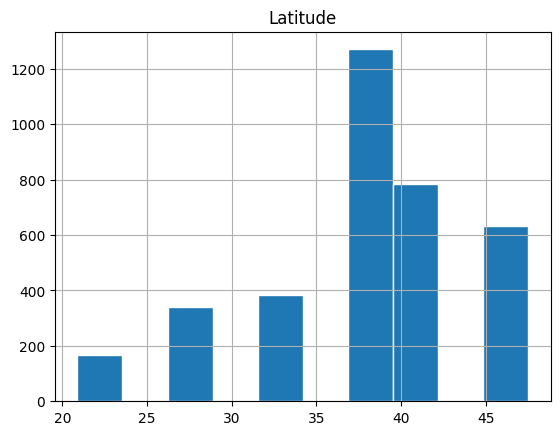

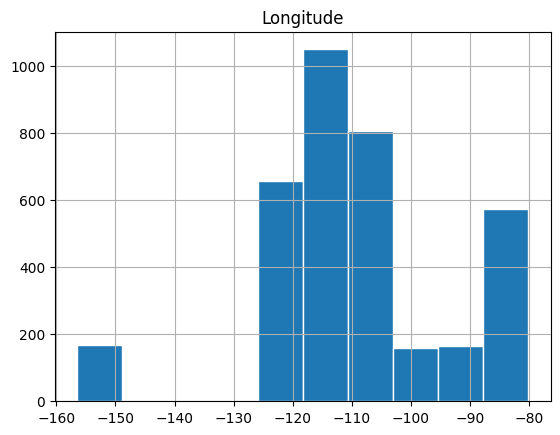

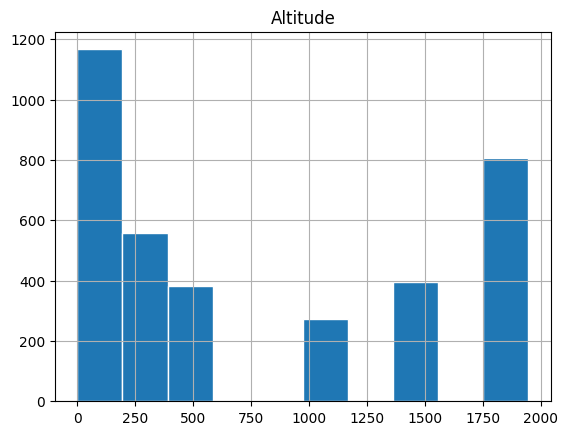

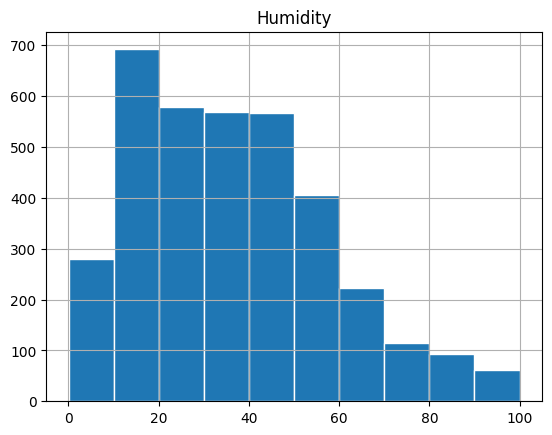

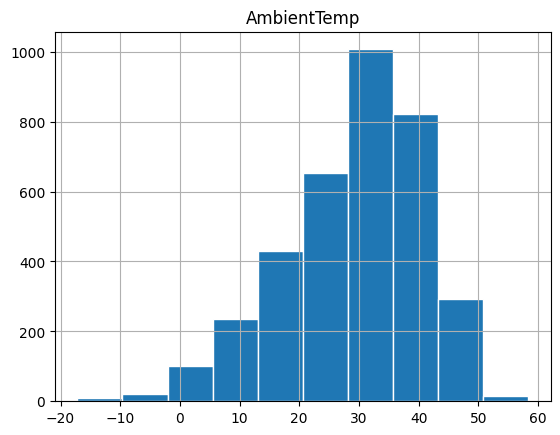

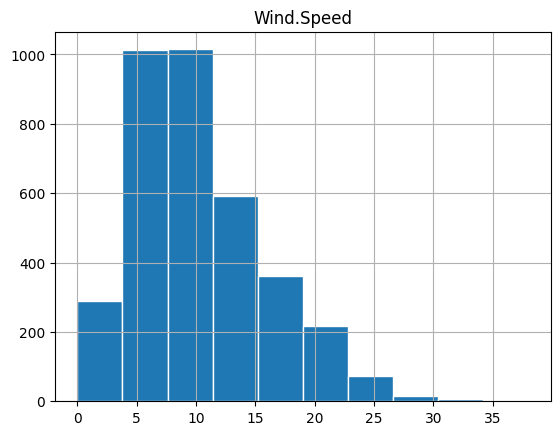

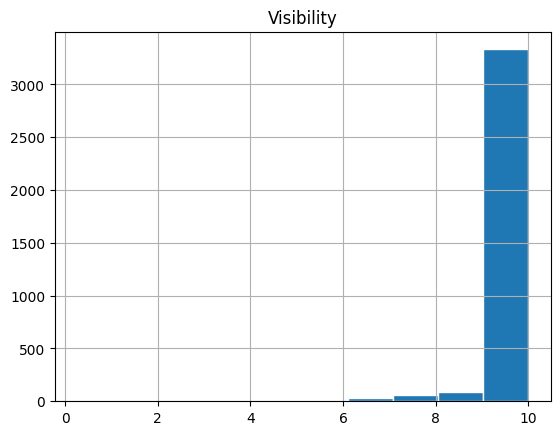

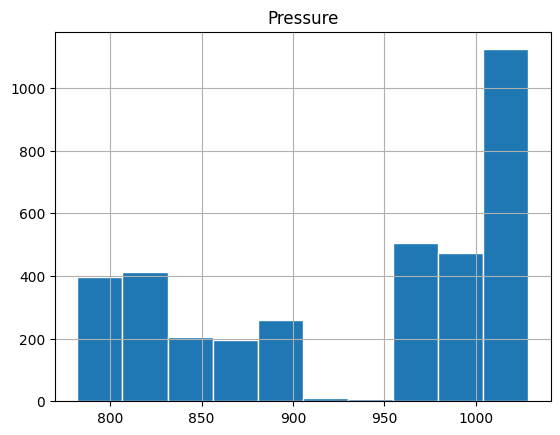

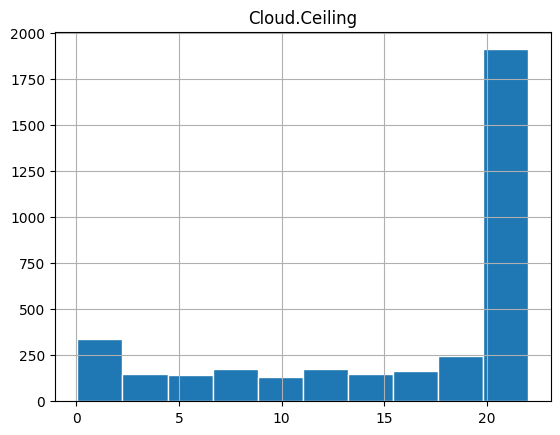

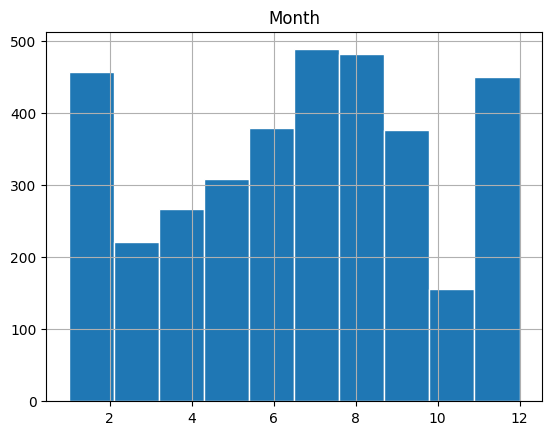

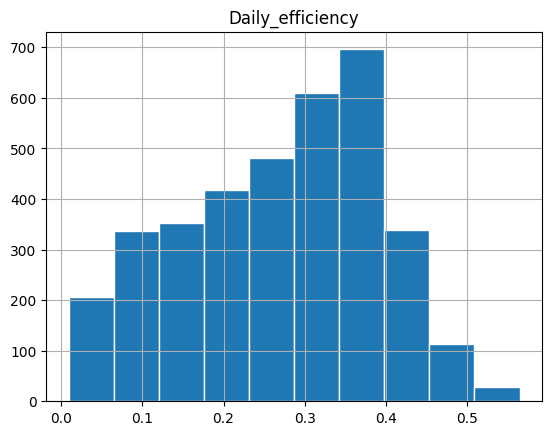

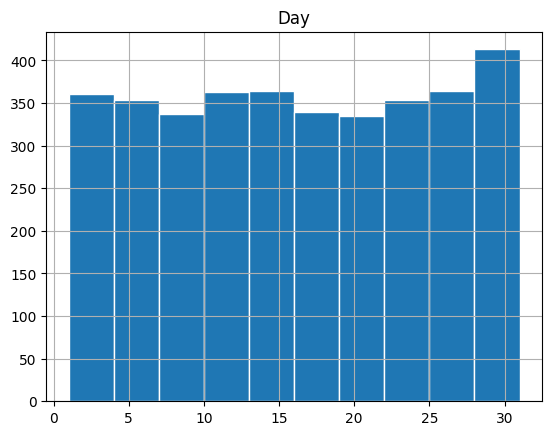

In [24]:
for col in df_solar.columns.values:
    plt.hist(df_solar[col], bins=10, edgecolor='white')
    plt.title(col)
    plt.grid(True)
    plt.show()

In [25]:
df_solar.head(10)

,Latitude,Longitude,Altitude,Humidity,AmbientTemp,Wind.Speed,Visibility,Pressure,Cloud.Ceiling,Month,Daily_efficiency,Day
0,26.98,-80.11,2.0,36.097718,38.398038,13.750000,10.000000,1013.675000,5.242304,5.0,0.390673,23
1,26.98,-80.11,2.0,39.012452,39.214906,18.800000,10.000000,1009.100000,17.909174,5.0,0.339006,24
2,26.98,-80.11,2.0,87.121582,28.953932,10.666667,7.583333,1011.566667,1.285177,5.0,0.192824,25
3,38.95,-104.83,1947.0,10.343279,35.505829,16.428571,10.000000,786.942857,15.583228,5.0,0.322961,25
4,26.98,-80.11,2.0,39.345295,34.868848,7.166667,10.000000,1017.550000,18.668089,5.0,0.487729,26
5,38.95,-104.83,1947.0,49.156843,25.813761,15.000000,10.000000,795.842857,16.240693,5.0,0.298871,26
6,26.98,-80.11,2.0,47.125242,39.370080,5.000000,10.000000,1017.566667,11.439602,5.0,0.471887,27
7,38.95,-104.83,1947.0,79.681906,15.128402,10.250000,10.000000,800.741667,1.071828,5.0,0.125558,27
8,26.98,-80.11,2.0,33.306885,39.799768,6.500000,10.000000,1016.700000,22.005486,5.0,0.489777,28
9,38.95,-104.83,1947.0,16.476004,35.957217,9.285714,10.000000,805.214286,22.005486,5.0,0.419830,28


# Feature Matrix

In [26]:
X = df_solar.drop(columns = ['Daily_efficiency'])
y = df_solar['Daily_efficiency']
df_solar.shape

(3582, 12)

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3582 entries, 0 to 3581
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Latitude       3582 non-null   float64
 1   Longitude      3582 non-null   float64
 2   Altitude       3582 non-null   float64
 3   Humidity       3582 non-null   float64
 4   AmbientTemp    3582 non-null   float64
 5   Wind.Speed     3582 non-null   float64
 6   Visibility     3582 non-null   float64
 7   Pressure       3582 non-null   float64
 8   Cloud.Ceiling  3582 non-null   float64
 9   Month          3582 non-null   float64
 10  Day            3582 non-null   int32  
dtypes: float64(10), int32(1)
memory usage: 294.0 KB


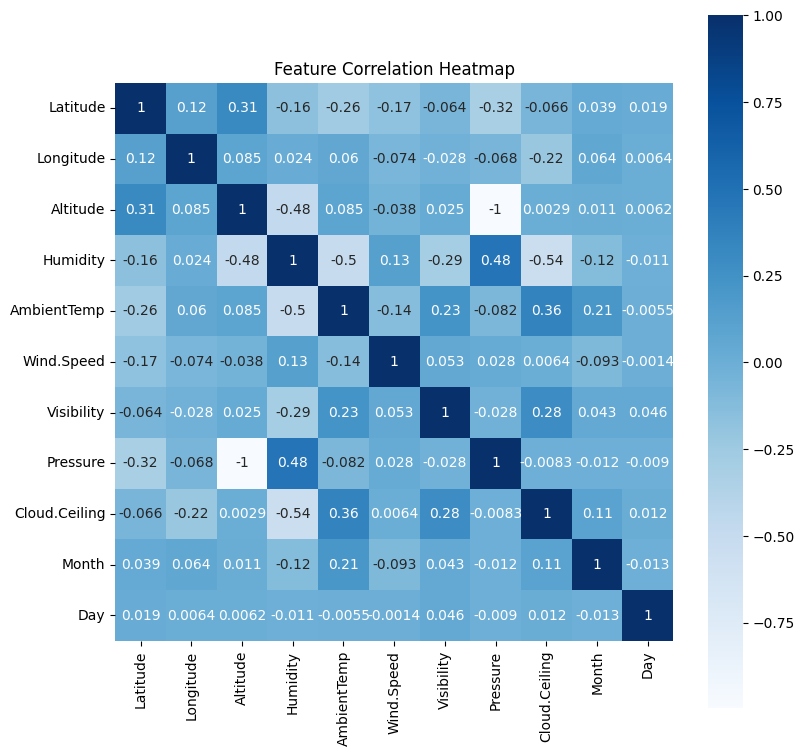

In [28]:
corr_df = X.corr()

plt.figure(figsize=(9, 9))
sns.heatmap(corr_df, cbar=True, square=True, annot=True, cmap="Blues")
plt.title('Feature Correlation Heatmap')
plt.show()

#### Collinearity & Multicollinearity


**What is it?**

- **Collinearity** refers to the situation when two independent variables are correlated with one another.
- **Multicollinearity** is the situation where one independent variable can be expressed as a linear combination of two or more other independent variables (in other words, the independent variables are in a linear relationship with *each other*).

**What does it do to our models?**

- When two or more predictor variables in a regression model are highly correlated, meaning that they contain similar information about the variance of the dependent variable. This can affect the performance and interpretation of various machine learning models.

Looking at correlation values greater than 0.7:

* None of these independent values are correlating with each other.



Separating dataset into testing and training dataset

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
X_test.shape, X_train.shape

((717, 11), (2865, 11))

### Solar Prediction

Models to try:
1. Decision Tree
2. Random Forest
3. Multiple Linear Regression

The evaluation metric to be used is r2 score, defined as:

$$R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$$

R² is easy to interpret and understand. It provides a straightforward percentage of how well the independent variables explain the variability in the dependent variable.

​
 
​




In [30]:
model_scores = {}

### Decision Tree Regression

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score


# Initialize the Random Forest Regressor
model_DF = DecisionTreeRegressor(
    splitter='best',
    
)

# Fit the model to the training data
model_DF.fit(X_train, y_train)



# Perform cross-validation
cv_scores = cross_val_score(model_DF, X_train, y_train, cv=10, scoring='r2')
model_scores['Decision_Trees'] = cv_scores.mean()


# Output the cross-validation scores
print(f'R^2 scores: {cv_scores}')
print(f'Average R^2: {cv_scores.mean():.4f}')


R^2 scores: [0.62435749 0.62819012 0.60449431 0.50972839 0.61566131 0.5119616
 0.63354573 0.53484179 0.63097474 0.65285204]
Average R^2: 0.5947


### Random forests

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  r2_score


# Initialize the Random Forest Regressor
model_RF = RandomForestRegressor(
    n_estimators= 450,
    max_depth = 20,
    min_samples_split = 4,
    min_samples_leaf= 2,
    max_features = 'sqrt'
)

# Fit the model to the training data
model_RF.fit(X_train, y_train)



# Perform cross-validation
cv_scores = cross_val_score(model_RF, X_train, y_train, cv=10, scoring='r2')
model_scores['Random_forest'] = cv_scores.mean()

# Output the cross-validation scores
print(f'R^2 scores: {cv_scores}')
print(f'Average R^2: {cv_scores.mean():.4f}')


R^2 scores: [0.84589016 0.81898394 0.82491841 0.77454139 0.79546338 0.73983607
 0.78618208 0.76894415 0.80392034 0.79376692]
Average R^2: 0.7952


### Multiple Linear Regression


In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression



pipeline = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("regression", LinearRegression())
])

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='r2')
model_scores['Linear_Regression'] = cv_scores.mean()

# Output the cross-validation scores
print(f'R^2 scores: {cv_scores}')
print(f'Average R^2: {cv_scores.mean():.4f}')

R^2 scores: [0.65300299 0.64169255 0.63428313 0.6240931  0.58773006 0.55928447
 0.61885649 0.60318219 0.62300901 0.59434082]
Average R^2: 0.6139


In [34]:
model_comparison_df = pd.DataFrame.from_dict(model_scores, orient="index", columns=['mean r2 score'])
model_comparison_df.sort_values("mean r2 score", ascending=False)

# print(model_scores)

,mean r2 score
Random_forest,0.795245
Linear_Regression,0.613947
Decision_Trees,0.594661


From the above we can see that Random Forest gave the best r2 score.

In [35]:
# Make predictions on the test set
y_pred = model_RF.predict(X_test)

# Evaluate the model's performance on the test set
r2 = r2_score(y_test, y_pred)

print(f'R^2 score on the test set: {r2:.4f}')

R^2 score on the test set: 0.7773


In [36]:
pickle.dump(model_RF, open("model.pkl", "wb"))

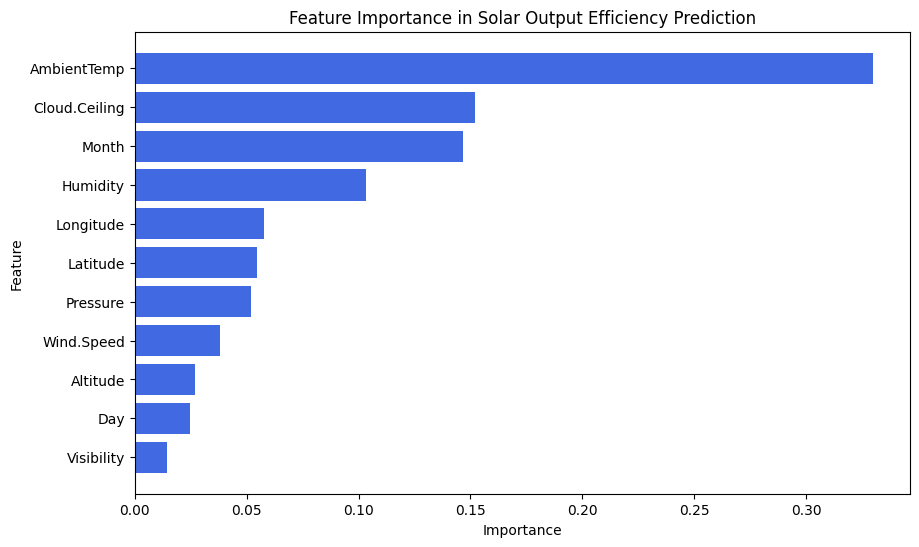

In [37]:
# Extract feature importance
feature_importances = model_RF.feature_importances_
features_list = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': features_list,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='royalblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Solar Output Efficiency Prediction')
plt.gca().invert_yaxis()
plt.show()